In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold   
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from sklearn import svm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df_test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/janata_hack/test_VsU9xXK.csv")
df_train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/janata_hack/train_Wc8LBpr.csv")

In [3]:
df_train.head()

,Trip_ID,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
0,T0005689460,6.77,B,1.0,2.42769,A,A,3.90500,0,40.0,46,60,Female,2
1,T0005689461,29.47,B,10.0,2.78245,B,A,3.45000,0,38.0,56,78,Male,2
2,T0005689464,41.58,NaN,10.0,NaN,NaN,E,3.50125,2,NaN,56,77,Male,2
3,T0005689465,61.56,C,10.0,NaN,NaN,A,3.45375,0,NaN,52,74,Male,3
4,T0005689467,54.95,C,10.0,3.03453,B,A,3.40250,4,51.0,49,102,Male,2


In [4]:
df_train.shape

(131662, 14)

In [5]:
df_train = df_train.drop(df_train.loc[df_train['Surge_Pricing_Type'].isnull()].index)

In [6]:
y_train = df_train.iloc[:,13]

In [7]:
frames = [df_train,df_test]
df = pd.concat(frames, keys=['x', 'y'])

df

Trip_ID  Trip_Distance  ...  Gender  Surge_Pricing_Type
x 0      T0005689460           6.77  ...  Female                 2.0
  1      T0005689461          29.47  ...    Male                 2.0
  2      T0005689464          41.58  ...    Male                 2.0
  3      T0005689465          61.56  ...    Male                 3.0
  4      T0005689467          54.95  ...    Male                 2.0
...              ...            ...  ...     ...                 ...
y 87390  T0005908503          29.43  ...  Female                 NaN
  87391  T0005908504          14.83  ...  Female                 NaN
  87392  T0005908505          37.86  ...    Male                 NaN
  87393  T0005908511          10.63  ...    Male                 NaN
  87394  T0005908515          37.96  ...  Female                 NaN

[219057 rows x 14 columns]

In [8]:
df.drop('Trip_ID', axis = 1, inplace = True)

In [9]:
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(25)

,Total,Percent
Var1,117819,0.537846
Surge_Pricing_Type,87395,0.398960
Confidence_Life_Style_Index,33520,0.153020
Life_Style_Index,33520,0.153020
Type_of_Cab,33368,0.152326
Customer_Since_Months,9886,0.045130
Gender,0,0.000000
Var3,0,0.000000
Var2,0,0.000000
Cancellation_Last_1Month,0,0.000000


In [10]:
df.drop('Surge_Pricing_Type', axis = 1, inplace = True)
df.drop('Var1', axis = 1, inplace = True)

In [11]:
df.dtypes

Trip_Distance                  float64
Type_of_Cab                     object
Customer_Since_Months          float64
Life_Style_Index               float64
Confidence_Life_Style_Index     object
Destination_Type                object
Customer_Rating                float64
Cancellation_Last_1Month         int64
Var2                             int64
Var3                             int64
Gender                          object
dtype: object

In [12]:
df['Life_Style_Index'].fillna(df['Life_Style_Index'].mean(), inplace = True)
df['Customer_Since_Months'].fillna(df['Customer_Since_Months'].median(), inplace = True)
for column in ['Type_of_Cab','Confidence_Life_Style_Index']:
    df[column].fillna(df[column].mode()[0], inplace=True)

In [13]:
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(25)

,Total,Percent
Gender,0,0.0
Var3,0,0.0
Var2,0,0.0
Cancellation_Last_1Month,0,0.0
Customer_Rating,0,0.0
Destination_Type,0,0.0
Confidence_Life_Style_Index,0,0.0
Life_Style_Index,0,0.0
Customer_Since_Months,0,0.0
Type_of_Cab,0,0.0


In [14]:
df.describe()

,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var2,Var3
count,219057.000000,219057.000000,219057.000000,219057.000000,219057.000000,219057.000000,219057.000000
mean,44.158725,6.005775,2.802594,2.848632,0.782915,51.186586,75.065777
std,25.507368,3.544106,0.208288,0.981100,1.036244,4.974497,11.580112
min,0.310000,0.000000,1.317850,0.001250,0.000000,40.000000,52.000000
25%,24.560000,3.000000,2.688050,2.152500,0.000000,48.000000,67.000000
50%,38.140000,6.000000,2.802594,2.895000,0.000000,50.000000,74.000000
75%,60.720000,10.000000,2.913910,3.581250,1.000000,54.000000,82.000000
max,109.230000,10.000000,4.875110,5.000000,8.000000,124.000000,206.000000


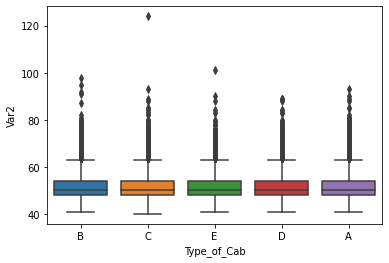

In [15]:
sns.boxplot(x='Type_of_Cab', y= 'Var2', data=df_train)

In [16]:
df.skew(axis=0).sort_values(ascending= False)

Cancellation_Last_1Month    1.544260
Var2                        1.167965
Var3                        0.819039
Trip_Distance               0.726008
Life_Style_Index            0.223860
Customer_Rating            -0.192665
Customer_Since_Months      -0.247014
dtype: float64

In [17]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
c = ['Trip_Distance', 'Customer_Since_Months','Life_Style_Index', 'Customer_Rating','Cancellation_Last_1Month','Var2','Var3' ]
df[c] = scaler.fit_transform(df[c])

In [18]:
num_feats = df.select_dtypes(exclude = ['object']).columns
df[num_feats] = np.sqrt(df[num_feats])

In [19]:
df.describe()

,Trip_Distance,Customer_Since_Months,Life_Style_Index,Customer_Rating,Cancellation_Last_1Month,Var2,Var3
count,219057.000000,219057.000000,219057.000000,219057.000000,219057.000000,219057.000000,219057.000000
mean,0.606337,0.714832,0.644441,0.741446,0.209527,0.356358,0.374433
std,0.186903,0.299322,0.045614,0.140988,0.232300,0.078632,0.097864
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.471848,0.547723,0.620632,0.656016,0.000000,0.308607,0.312094
50%,0.589338,0.774597,0.646053,0.760851,0.000000,0.345033,0.377964
75%,0.744733,1.000000,0.669833,0.846274,0.353553,0.408248,0.441367
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
df1 = pd.get_dummies(df, columns=list(df.select_dtypes(exclude=np.number)))
df1.head()

Trip_Distance  Customer_Since_Months  ...  Gender_Female  Gender_Male
x 0       0.243536               0.316228  ...              1            0
  1       0.517416               1.000000  ...              0            1
  2       0.615550               1.000000  ...              0            1
  3       0.749893               1.000000  ...              0            1
  4       0.708274               1.000000  ...              0            1

[5 rows x 31 columns]

In [21]:
X_train = df1.xs('x')
X_test = df1.xs('y')

In [ ]:
xgb = XGBClassifier(max_depth=10, n_estimators=80, learning_rate=0.1)
xgb_model = xgb.fit(X_train,y_train)

scores_xgb = cross_val_score(xgb_model,X_train,y_train,cv=5)

scores_xgb.mean()

In [22]:
rf = RandomForestClassifier(max_features=12, max_depth=10, n_estimators=40, criterion='entropy')
rf_model = rf.fit(X_train,y_train)

scores_rf = cross_val_score(rf_model, X_train, y_train, cv=5)
scores_rf.mean()

0.6850495917398716

In [23]:
lr = LogisticRegression(solver = 'lbfgs')
lr_model = lr.fit(X_train,y_train)
scores_lr = cross_val_score(lr_model, X_train, y_train, cv=5)
scores_lr.mean()

0.6804620946972532

In [24]:
sample = pd.read_csv('/content/drive/My Drive/Colab Notebooks/janata_hack/sample_submission_NoPBkjr.csv')
sample.iloc[:,1] = pd.Series(rf_model.predict(X_test))

In [25]:
sample.to_csv('janata_submission_09.csv', index = False)